<a href="https://colab.research.google.com/github/dinhhungGM/StockPrediction/blob/main/Stock_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Master_UIT/Công nghệ thương mại điện tử/Reports/Code

/content/drive/MyDrive/Master_UIT/Công nghệ thương mại điện tử/Reports/Code


If you want to use a LSTM model to predict the future closing price of a particular bank's stock, you can use the following features:

1. Historical closing prices: You can use the closing prices from previous days as input to the LSTM model. This will allow the model to learn patterns in the time series data and make predictions based on past trends.

2. Historical trading volume: Trading volume is an important indicator of market sentiment and can be used as a feature to predict future price movements. By including the trading volume as an input to the LSTM model, you can capture the relationship between volume and price.

3. Historical opening, high and low prices: Including the opening, high and low prices from previous days as input features can provide additional context for the model and help it learn more complex patterns in the data.

4. Technical indicators: You can also include technical indicators such as moving averages, relative strength index (RSI), or moving average convergence divergence (MACD) as input features. These indicators can provide additional insights into the stock's performance and help the model make more accurate predictions.

It's worth noting that the choice of input features depends on the specific dataset and problem you are trying to solve. You may need to experiment with different combinations of features to find the best set of inputs for your model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Load the datasets
acb_df = pd.read_csv('./Datasets/excel_acb.csv')
vcb_df = pd.read_csv('./Datasets/excel_vcb.csv')
stb_df = pd.read_csv('./Datasets/excel_stb.csv')
bid_df = pd.read_csv('./Datasets/excel_bid.csv')

In [4]:
acb_df.head()

,<Ticker>,<DTYYYYMMDD>,<OpenFixed>,<HighFixed>,<LowFixed>,<CloseFixed>,<Volume>
0,ACB,20061121,120.0,150.0,119.0,130.2,56500
1,ACB,20061122,143.2,143.2,130.0,134.7,62300
2,ACB,20061123,145.0,145.0,130.0,138.4,69900
3,ACB,20061124,140.0,152.0,140.0,146.8,63600
4,ACB,20061127,146.8,161.4,135.0,146.8,42400


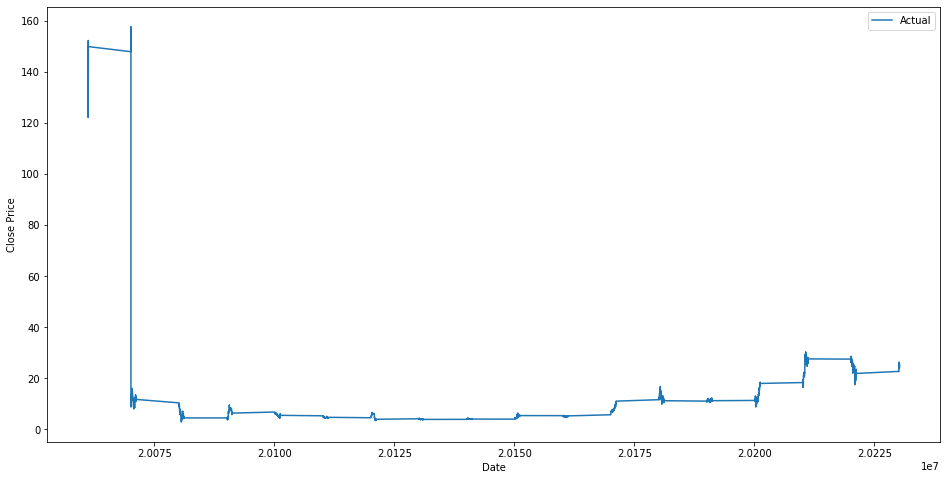

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(acb_df['<DTYYYYMMDD>'], acb_df['<CloseFixed>'])
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend(['Actual'])
plt.show()

In [8]:
loopback = 60

def load_data(ticker):
    data = pd.read_csv(f'./Datasets/excel_{ticker}.csv')
    # data = data.sort_values('<DTYYYYMMDD>')
    data['<DTYYYYMMDD>'] = pd.to_datetime(data['<DTYYYYMMDD>'], format='%Y%m%d')
    data = data.reset_index(drop=True)
    return data

def preprocess_data(data):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['<CloseFixed>']])
    X, y = [], []
    for i in range(loopback, len(data)):
        X.append(data_scaled[i-loopback:i,0])
        y.append(data_scaled[i,0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def build_model(X):
    # Build LSTM model
    model = Sequential()    
    model.add(LSTM(128, return_sequences=True, input_shape = (X.shape[1], 1)))
    # model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    # model.add(Dropout(0.25))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

def train_model(model, X_train, y_train, batch_size=1, epochs=1):
    filepath = "ACB_model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stop], validation_split=.1)
    return history

def predict(model, X_test, scaler):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

def plot_results(data, y_pred, ticker, closed_prices):
    fig, ax = plt.subplots(figsize=(16,8))

    ax.plot(data['<DTYYYYMMDD>'][num +loopback:][:7], closed_prices[:7], linestyle='--', marker='o')
    ax.plot(data['<DTYYYYMMDD>'][num + loopback:][:7], y_pred[:7],  marker='v')

    ax.set_title(f'Actual vs Predicted Close Price of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.legend(['Actual', 'Predicted'])
    plt.show()

def plot_results_overview(data, y_pred, ticker, closed_prices):
    fig, ax = plt.subplots(figsize=(16,8))

    ax.plot(data['<DTYYYYMMDD>'][num +loopback:], closed_prices, linestyle='--')
    ax.plot(data['<DTYYYYMMDD>'][num + loopback:], y_pred)

    ax.set_title(f'Actual vs Predicted Close Price of {ticker}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.legend(['Actual', 'Predicted'])
    plt.show()


In [ ]:
# Example usage for predicting Close price of ACB stock
data = load_data('acb')
X, y, scaler = preprocess_data(data)
model = build_model(X)

ratio = .8
num = int(len(X)*ratio)
X_train, y_train, X_test, y_test = X[:num], y[:num], X[num:], y[num:]

history = train_model(model, X_train, y_train, batch_size=16, epochs=10)
y_pred = predict(model, X_test, scaler)

Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 2.9461e-05 - accuracy: 3.4771e-04
Epoch 1: val_loss improved from inf to 0.00004, saving model to ACB_model.h5
180/180 [==============================] - 28s 130ms/step - loss: 2.9461e-05 - accuracy: 3.4771e-04 - val_loss: 3.5127e-05 - val_accuracy: 0.0000e+00
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 1.0817e-05 - accuracy: 3.4771e-04
Epoch 2: val_loss improved from 0.00004 to 0.00000, saving model to ACB_model.h5
180/180 [==============================] - 21s 117ms/step - loss: 1.0817e-05 - accuracy: 3.4771e-04 - val_loss: 2.9561e-06 - val_accuracy: 0.0000e+00
Epoch 3/10
180/180 [==============================] - ETA: 0s - loss: 7.0795e-06 - accuracy: 3.4771e-04
Epoch 3: val_loss did not improve from 0.00000
180/180 [==============================] - 24s 133ms/step - loss: 7.0795e-06 - accuracy: 3.4771e-04 - val_loss: 4.9460e-05 - val_accuracy: 0.0000e+00
Epoch 4/10
180/180 [=============

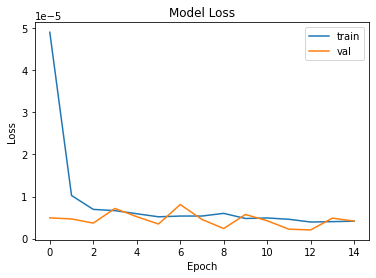

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

MSE: 0.827977980987432
RMSE: 0.9099329541166382


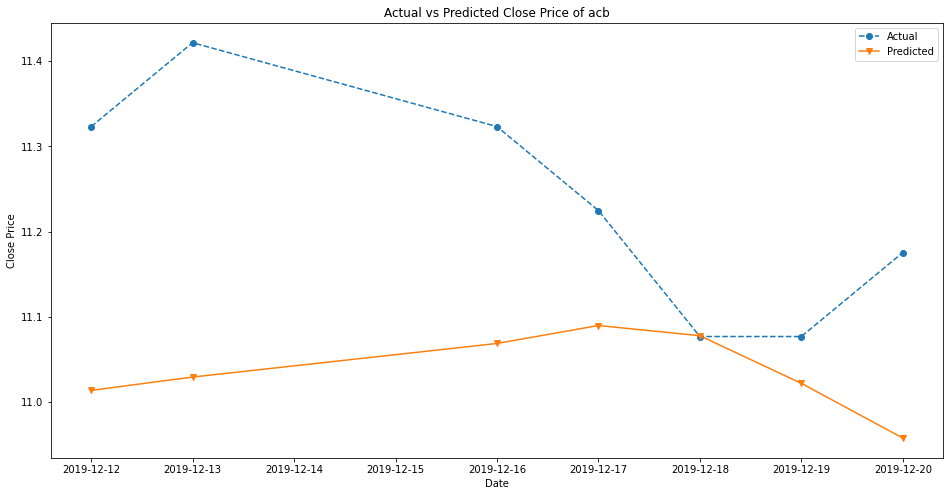

In [ ]:
close_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
MSE = np.mean((y_pred - close_prices)**2)
RMSE = np.sqrt(MSE)
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')
plot_results(data, y_pred, 'acb', close_prices)

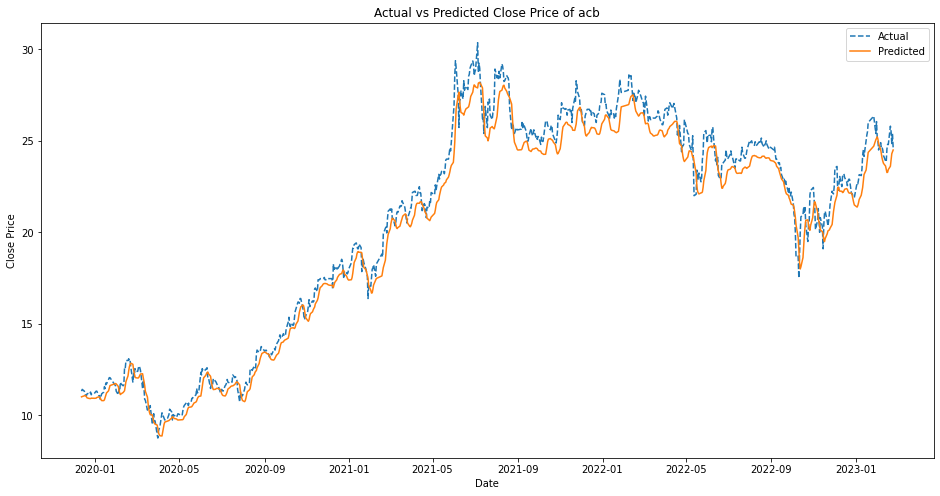

In [ ]:
plot_results_overview(data, y_pred, 'acb', close_prices)